# L-FTS with Lamellar Phase

<!-- This example demonstrates how to find the saddle-point solution of AB diblock copolymer systems with Anderson Mixing. -->
1. Saddle-point solutions for imaginary fields are efficiently searched using the Anderson mixing or linear response theory.

2. The real fields are updated using Leimkuhler-Matthews method
\begin{align}
\Omega_i({\bf r}, \tau+\delta\tau) &= \Omega_i({\bf r}, \tau) -λ_i\frac{\beta}{\rho_0}\frac{\delta H[\{\Omega_i\},\{w_j\}]}{\delta \Omega_i({\bf r}, \tau)} \delta\tau + \frac{\sigma_i}{2}\left(\mathcal{N}({\bf r}, \tau)+\mathcal{N}({\bf r}, \tau+\delta\tau)\right),  \ \ \ \ (\textrm{per monomer unit}) \\
\end{align}
where $\mathcal{N}$ is Gaussian noise and $\sigma_i^2 = \lambda_i\frac{2\delta\tau N^2}{\Delta V \rho_0}$.

3. This example uses pre-written `lfts.py` located in \${PYTHON_SITE_PACKAGES}\$/polymerfts

References:
* [(2009) Fast and accurate SCFT calculations for periodic block-copolymer morphologies using the spectral method with Anderson mixing](http://dx.doi.org/10.1140/epje/i2009-10534-3)
* [(2011) Efficiency of pseudo-spectral algorithms with Anderson mixing for the SCFT of periodic block-copolymer phases](http://dx.doi.org/10.1140/epje/i2011-11110-0)
* [(2021) Fluctuation correction for the order–disorder transition of diblock copolymer melts](https://doi.org/10.1063/5.0046167)
* [(2023) Efficient Langevin and Monte Carlo sampling algorithms: The case of field-theoretic simulations](https://doi.org/10.1063/5.0131183)
* (2025) Improved Algorithm for Identifying Partial Saddle-Points in Polymer Field Theoretic Simulations in press(?)

### 1. Setting simulation parameters 

Static simulation parameters:
\begin{align}
N &= 90 \\
\Delta s &= 1/N = 1/90 \\
R_0 & = bN^{1/2} \\
L_x &= 4.36 R_0 \\
L_y &= 4.36 R_0 \\
L_z &= 4.36 R_0 \\
V &= L_x L_y L_z \\ 
m_x &= 40 \\
m_y &= 40 \\
m_z &= 40 \\
b_A/b &= 1.0 \\
b_B/b &= 1.0 \\  
\chi_b N &= 17 \\
f_a &= 0.4 \\
\end{align}

Langevin dynamics parameters:
\begin{align}
\bar{N} &= 10000 \\
\Delta \tau N &= 8.0 \\
\end{align}


In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter
from polymerfts import lfts

# OpenMP environment variables
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"  # 0, 1
os.environ["OMP_NUM_THREADS"] = "2"  # 1 ~ 4

f = 0.4        # A-fraction of major BCP chain, f
eps = 1.0       # a_A/a_B, conformational asymmetry

params = {
    "platform":"cpu-mkl",           # choose platform among [cuda, cpu-mkl]

    #---------------- Simulation parameters -----------------------------
    "nx":[40, 40, 40],          # Simulation grid numbers
    "lx":[4.36, 4.36, 4.36],    # Simulation box size as a_Ref * N_Ref^(1/2) unit,
                                # where "a_Ref" is reference statistical segment length
                                # and "N_Ref" is the number of segments of reference linear homopolymer chain.

    "chain_model":"discrete",   # "discrete" or "continuous" chain model
    "ds":1/90,                  # Contour step interval, which is equal to 1/N_Ref.

    "segment_lengths":{         # Relative statistical segment length compared to "a_Ref.
        "A":1.0, 
        "B":1.0, },

    "chi_n": {"A,B":17.0},     # Bare interaction parameter, Flory-Huggins params * N_Ref

    "distinct_polymers":[{      # Distinct Polymers
        "volume_fraction":1.0,  # Volume fraction of polymer chain
        "blocks":[              # AB diBlock Copolymer
            {"type":"A", "length":f, }, # A-block
            {"type":"B", "length":1-f}, # B-block
        ],},],
        
    "langevin":{                # Langevin Dynamics
        "max_step":100,         # Langevin steps for simulation
        "dt":8.0,               # Langevin step interval, delta tau*N_Ref
        "nbar":10000,           # Invariant polymerization index, nbar of N_Ref
    },
    
    "recording":{                           # Recording Simulation Data
        "dir":"data_simulation",            # Directory name
        "recording_period":100, # 10000     # Period for recording concentrations and fields
        "sf_computing_period":10,           # Period for computing structure function
        "sf_recording_period":100, # 100000 # Period for recording structure function
    },

    "saddle":{                # Iteration for the pressure field 
        "max_iter" :100,      # Maximum number of iterations
        "tolerance":1e-4,     # Tolerance of incompressibility 
    },

    "compressor":{
        # "name":"am",                # Anderson Mixing
        # "name":"lr",                # Linear Response
        "name":"lram",              # Linear Response + Anderson Mixing
        "max_hist":20,              # Maximum number of history
        "start_error":5e-1,         # When switch to AM from simple mixing
        "mix_min":0.01,             # Minimum mixing rate of simple mixing
        "mix_init":0.01,            # Initial mixing rate of simple mixing
    },

    "verbose_level":1,      # 1 : Print at each langevin step.
                            # 2 : Print at each saddle point iteration.
}

### 2. Initial potential fields

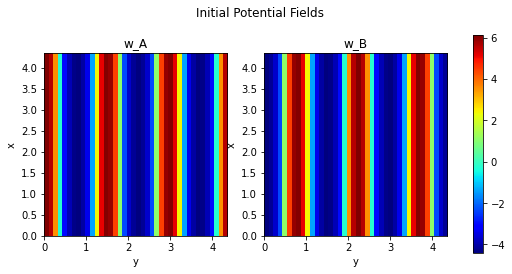

In [28]:
nx = params["nx"]
lx = params["lx"]

# Set initial fields
input_data = loadmat("LamellaInput.mat", squeeze_me=True)
w_A = np.reshape(input_data["w_A"], nx)
w_B = np.reshape(input_data["w_B"], nx)

w = {"A": w_A, "B": w_B}  # potential field dictionary

# Plot each image with the same vmin and vmax
vmin = min(w_A.min(), w_B.min())
vmax = max(w_A.max(), w_B.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Initial Potential Fields")
im = axes[0].imshow(w_A[0,:,:], extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
im = axes[1].imshow(w_B[0,:,:], extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
axes[0].set(title='w_A', xlabel='y', ylabel='x')
axes[1].set(title='w_B', xlabel='y', ylabel='x')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()

### 3. Initialization

One of eigenvalues is zero for given chiN values.
==================== MKL Version ====================------------ Polymer Field Theory for Multimonomer ------------
Eigenvalues:
	 [-17.   0.]
Eigenvectors [v1, v2, ...] :
	 [[ 1.  1.]
	 [-1.  1.]]
Mapping matrix A:
	 [[ 1.  1.]
	 [-1.  1.]]
Real Fields:  [0]
Imaginary Fields:  [1]
In Hamiltonian:
	reference energy:  4.25
	coefficients of int of mu(r)/V:  [-0. -1.]
	coefficients of int of mu(r)^2/V:  [0.05882353 0.        ]
	dH_ref/dχN:  {'A,B': 0.24999999999053554}
	d(coef of mu(r))/dχN:  {'A,B': array([0., 0.])}
	d(coef of mu(r)^2)/dχN:  {'A,B': array([-0.00346021,  0.        ])}
Monomer color:  {'A': 'red', 'B': 'blue'}

Major version:           2021
Minor version:           0
Update version:          4
Product status:          Product
Build:                   20210904
Platform:                Intel(R) 64 architecture
Processor optimization:  Intel(R) Architecture processors
---------- Simulation Parameters ----------
Platform : cpu

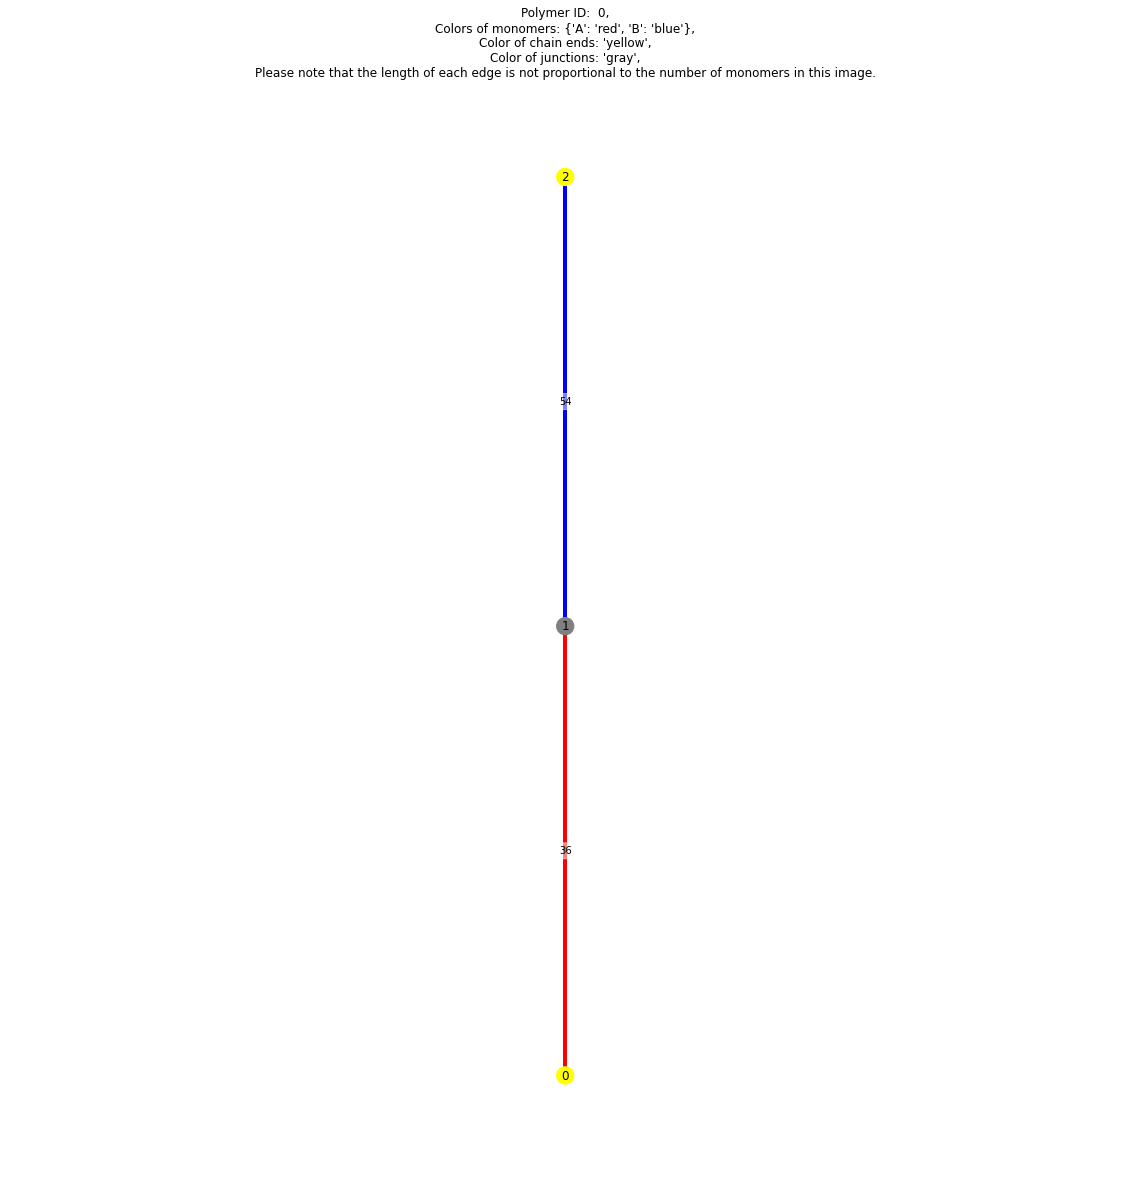

In [29]:
# Set random seed
# If you want to obtain different results for each execution, set random_seed=None
random_seed = 12345
np.random.seed(random_seed)

# Initialize simulation
simulation = lfts.LFTS(params=params, random_seed=random_seed)

### 4. Run

In [30]:
# Run
simulation.run(initial_fields={"A": w_A, "B": w_B})

---------- Run  ----------
iterations, mass error, total partitions, Hamiltonian, incompressibility error (or saddle point error)
       6    7.576E-14  [ 3.3997225E+00  ]     3.945717170   [6.8350592E-05 ]
Langevin step:  1
       8   -1.502E-14  [ 8.8496880E+00  ]     5.302695587   [3.7325254E-05 ]
Langevin step:  2
       8   -7.765E-15  [ 1.5278587E+01  ]     7.448860240   [9.8964395E-05 ]
Langevin step:  3
       9   -3.889E-15  [ 1.4894703E+01  ]     7.507150219   [6.7184075E-05 ]
Langevin step:  4
       9   -6.459E-15  [ 1.4340864E+01  ]     7.550531379   [5.1552092E-05 ]
Langevin step:  5
       9    2.720E-15  [ 1.3670564E+01  ]     7.553096387   [4.2759056E-05 ]
Langevin step:  6
       9    5.643E-15  [ 1.2859043E+01  ]     7.575711736   [4.7100411E-05 ]
Langevin step:  7
       9    2.095E-17  [ 1.2372404E+01  ]     7.570514170   [5.9903123E-05 ]
Langevin step:  8
       9   -2.835E-15  [ 1.2047624E+01  ]     7.558225074   [4.0922070E-05 ]
Langevin step:  9
       9    4.6

### 5. Display the results

In [31]:
# Get the box size
lx = calculation.cb.get_lx()
print("Box size:", lx)

# Get the ensemble average concentration for each monomer type
phi_A = np.reshape(calculation.phi["A"], nx)
phi_B = np.reshape(calculation.phi["B"], nx)

# Plot each image with the same vmin and vmax
vmin = min(phi_A.min(), phi_B.min())
vmax = max(phi_A.max(), phi_B.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Concentrations")
im = axes[0].imshow(phi_A, extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
im = axes[1].imshow(phi_B, extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
axes[0].set(title='phi_A', xlabel='y', ylabel='x')
axes[1].set(title='phi_B', xlabel='y', ylabel='x')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()


NameError: name 'calculation' is not defined